# **Laboratorio 11: Pienso, luego predigo 💡**

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos - Otoño 2025</strong></center>

### Cuerpo Docente:

- Profesores: Stefano Schiappacasse, Sebastián Tinoco
- Auxiliares: Melanie Peña, Valentina Rojas
- Ayudantes: Angelo Muñoz, Valentina Zúñiga

### **Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados**

- Nombre de alumno 1: Juan Miño
- Nombre de alumno 2: Diego Espinoza

### **Link de repositorio de GitHub:** [Repositorio Laboratorio 11](https://github.com/juansebm/MDS7202/tree/main/Lab%2011%20-%20Agentes%20Autonomos)

## **Temas a tratar**

- Reinforcement Learning
- Large Language Models

## **Reglas:**

- **Grupos de 2 personas**
- Fecha de entrega: 6 días de plazo con descuento de 1 punto por día. Entregas Martes a las 23:59.
- Instrucciones del lab el viernes a las 16:15 en formato online. Asistencia no es obligatoria, pero se recomienda fuertemente asistir.
- <u>Prohibidas las copias</u>. Cualquier intento de copia será debidamente penalizado con el reglamento de la escuela.
- Tienen que subir el laboratorio a u-cursos y a su repositorio de github. Labs que no estén en u-cursos no serán revisados. Recuerden que el repositorio también tiene nota.
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Pueden usar cualquier material del curso que estimen conveniente.

### **Objetivos principales del laboratorio**

- Resolución de problemas secuenciales usando Reinforcement Learning
- Habilitar un Chatbot para entregar respuestas útiles usando Large Language Models.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

## **1. Reinforcement Learning (2.0 puntos)**

En esta sección van a usar métodos de RL para resolver dos problemas interesantes: `Blackjack` y `LunarLander`.

In [2]:
!pip install -qqq gymnasium stable_baselines3
!pip install -qqq swig
!pip install -qqq gymnasium[box2d]

zsh:1: no matches found: gymnasium[box2d]


### **1.1 Blackjack (1.0 puntos)**

<p align="center">
  <img src="https://www.recreoviral.com/wp-content/uploads/2016/08/s3.amazonaws.com-Math.gif"
" width="400">
</p>

La idea de esta subsección es que puedan implementar métodos de RL y así generar una estrategia para jugar el clásico juego Blackjack y de paso puedan ~~hacerse millonarios~~ aprender a resolver problemas mediante RL.

Comencemos primero preparando el ambiente. El siguiente bloque de código transforma las observaciones del ambiente a `np.array`:


In [2]:
import gymnasium as gym
from gymnasium.spaces import MultiDiscrete
import numpy as np

class FlattenObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super(FlattenObservation, self).__init__(env)
        self.observation_space = MultiDiscrete(np.array([32, 11, 2]))

    def observation(self, observation):
        return np.array(observation).flatten()

# Create and wrap the environment
env = gym.make("Blackjack-v1")
env = FlattenObservation(env)

#### **1.1.1 Descripción de MDP (0.2 puntos)**

Entregue una breve descripción sobre el ambiente [Blackjack](https://gymnasium.farama.org/environments/toy_text/blackjack/) y su formulación en MDP, distinguiendo de forma clara y concisa los estados, acciones y recompensas.

El ambiente Blackjack es un entorno de decisión secuencial modelado como un Proceso de Decisión de Markov (MDP), donde un jugador busca vencer al dealer obteniendo una suma de cartas lo más cercana posible a 21, sin pasarse. Recordemos que el Blackjack bajo la formulación de MDP cumple con la propiedad de Markov que dice que la probabilidad del siguiente estado y recompensa depende únicamente del estado actual y la acción tomada, no del historial entero. 

- Estados (Observaciones): Cada estado está representado por una tupla de tres valores:
    - player_sum: suma actual de las cartas del jugador (rango 4–21),
    - dealer_showing: valor de la carta visible del dealer (1–10),
    - usable_ace: indicador binario (1 si el jugador tiene un as usable, es decir, que puede contar como 11 sin pasar de 21, y 0 en caso contrario).

- Acciones: El agente (jugador) puede elegir entre dos acciones:
    - hit (1): pedir una carta adicional,
    - stick (0): detenerse y pasar el turno al dealer.

- Recompensas:
    - Victoria: +1
    - Derrota: -1
    - Empate: 0
    - Victoria con Blackjack natural (21 con dos cartas): +1.5 (si natural=True), o +1 si se ignora la bonificación.

- Término del episodio: El episodio finaliza si:
    - el jugador hace hit y su mano supera 21 (bust)
    - el jugador hace stick y se resuelve el juego contra el dealer.

Dinámica del juego:
El jugador comienza con dos cartas visibles; el dealer con una visible y una oculta. Las cartas se extraen con reemplazo. Las figuras (J, Q, K) valen 10, los ases valen 1 u 11 (si no provocan bust), y el resto tiene su valor numérico.

Si el jugador elige hit y su suma supera 21, pierde inmediatamente (bust). Si elige stick, el dealer revela su carta oculta y roba hasta alcanzar una suma de 17 o más. Si el dealer se pasa, el jugador gana. Si ambos permanecen dentro del límite, gana quien tenga la suma más alta; si empatan, el resultado es un empate.

#### **1.1.2 Generando un Baseline (0.2 puntos)**

Simule un escenario en donde se escojan acciones aleatorias. Repita esta simulación 5000 veces y reporte el promedio y desviación de las recompensas. ¿Cómo calificaría el performance de esta política? ¿Cómo podría interpretar las recompensas obtenidas?

In [3]:
recompensas = []
n_simulaciones = 5000
n_movimientos_maximo = 100000

for episodio in range(n_simulaciones):
    done = truncado = False
    estado, info = env.reset()
    recompensa_total = 0
    
    for paso_temporal in range(n_movimientos_maximo):
        accion = env.action_space.sample()
        estado, recompensa, done, truncado, info = env.step(accion)
        recompensa_total += recompensa     
        if done or truncado:
            break
    recompensas.append(recompensa_total)    

env.close()

average_recompensa = np.mean(recompensas)
std_recompensa = np.std(recompensas)

print(f"Promedio de recompensa en 5000 episodios: {average_recompensa:.4f}")
print(f"Desviación estándar: {std_recompensa:.4f}")

Promedio de recompensa en 5000 episodios: -0.3934
Desviación estándar: 0.8963


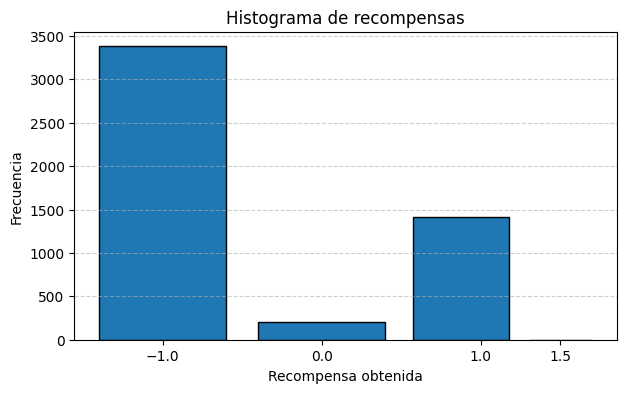

In [4]:
import matplotlib.pyplot as plt

bins = [-1.5, -0.5, 0.5, 1.25, 1.75]#estos bins sirven para que se vean las recompensas

plt.figure(figsize=(7, 4))
plt.hist(recompensas, bins=bins, edgecolor='black', rwidth=0.8)

plt.xticks([-1, 0, 1, 1.5])
plt.xlabel("Recompensa obtenida")
plt.ylabel("Frecuencia")
plt.title("Histograma de recompensas")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


¿Cómo calificaría el performance de esta política?

- El rendimiento de la política aleatoria es pobre, porque la mayoría de las simulaciones muestran recompensas negativas. Ahora bien, esta política sirve como línea base o baseline para comparar agentes entrenados mediante aprendizaje por refuerzo o reinforcemente learning, cualquier política que mejore el promedio de -0.38 podrá considerarse una mejora. 

¿Cómo podría interpretar las recompensas obtenidas?

- Un promedio negativo de las recompensas para 5000 simulaciones/partidas y una cantidad máxima de 100 pasos/movimientos permitidos por partida, implica que las partidas en donde se pierde tomando aleatoriamente decisiones es mayor que aquellas en las que se gana. Es decir, en nuestro caso la cantidad de partidas perdidas es aproximadamente el doble que la cantidad de partidas ganadas. Por otro lado, podemos decir que el puntaje de las partidas empatadas no afecta en nada porque la recompensa de dichas partidas es nula, por lo que en el promedio de las recompensas nunca se verán reflejadas las partidas empatadas o que quedan en `draw`. Esto además, se podría interpretar como que el mecanismo, aunque sea aleatorio, nos diese el resultado de un dado o moneda cargada, con la probabilidad dada por la ley de Laplace más inclinada hacia el caso de partidas perdidas. 

#### **1.1.3 Entrenamiento de modelo (0.2 puntos)**

A partir del siguiente [enlace](https://stable-baselines3.readthedocs.io/en/master/guide/algos.html), escoja un modelo de `stable_baselines3` y entrenelo para resolver el ambiente `Blackjack`.

Podemos ver que `Stable Baselines3 (SB3)` es una biblioteca de python que se usa para entrenar y evaluar agentes de aprendizaje por refuerzo (RL), y además es implementada sobre PyTorch (usada por lo demás, para implementar modelos de RL que son bastantes cercanos al estado del arte). Por otro lado, esta ofrece una colección de algoritmos RL listos para usar con soporte para entornos de Gymnasium. De la clase de aprendizaje reforzado, podemos tomar como ejemplo el alfortitmo DQN (también conocido como [Deep Q-Network](https://markelsanz14.medium.com/introducción-al-aprendizaje-por-refuerzo-parte-3-q-learning-con-redes-neuronales-algoritmo-dqn-bfe02b37017f)).

 En particular, según dicha referencia, ese algoritmo combina el algoritmo Q-learning con redes neuronales profundas (que son fantásticas para aproximar funciones no lineales), que en realidad son dos redes neuronales, la primera de las cuales aproxima la función Q(s, a, $\theta$) (del estado `s` y acción `a` actuales) mientras que la segunda parametrizada por $\theta'$ aproxima los valores Q pero del siguiente estado s' y acción a'. Aquí el aprendizaje ocurre en la red primera y no en la objetivo (la segunda), donde los parametros del aprendizaje de la primera se copian a la segunda transmitiendo el aprendizaje. Aquí queremos minimizar una función de pérdida que es la resta de la ecuación de bellman en DQN. 

Esta función de pérdida se minimiza usando el algoritmo de descenso de gradientes. En este contexto, el agente no es más que el objeto `model`, el cual usa el algoritmo DQN como su cerebro para aprender/tomar decisiones, porque por definición un agente es el componente que 1) observa el estado del entorno o ambiente, 2) toma decisiones, 3) recibe recompensas, 4) actualiza su política para mejorar su comportamiento. 

In [5]:
from stable_baselines3 import DQN

#ahora inicializamos el agente
model = DQN("MlpPolicy", env, verbose=0)

#lo entrenamos para poder resolver el ambiente Blackjack
model.learn(total_timesteps=int(2e5), progress_bar=True)

Output()

#### **1.1.4 Evaluación de modelo (0.2 puntos)**

Repita el ejercicio 1.1.2 pero utilizando el modelo entrenado. ¿Cómo es el performance de su agente? ¿Es mejor o peor que el escenario baseline?

Primero que todo, exportamos el modelo entrenado a un archivo .zip en pocas líneas de código:

In [ ]:
model.save("dqn_blackjack")
del model
model = DQN.load("dqn_blackjack", env=env)

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy

recompensa_promedio, desviacion_recompensa = evaluate_policy(model, model.get_env(), n_eval_episodes=1000)
recompensa_promedio, desviacion_recompensa

(-0.114, 0.9460465104845533)

¿Cómo es el performance de su agente?

- El agente que usa DQN por detrás tiene un promedio de recompensas de -0.3, lo que es ligeramente mayor al caso del baseline que elegía aleatoriamente los movimientos por cada partida de blackjack (-0.053 que puede cambiar y -0.38 respectivamente).

¿Es mejor o peor que el escenario baseline?

- El performance, como se dijo en la parte anterior, es mejor que el escenario baseline porque el agente entrenado aprende una política que maximiza la recompensa esperada, mientras que la política aleatoria no incorpora ninguna estrategia.

#### **1.1.5 Estudio de acciones (0.2 puntos)**

Genere una función que reciba un estado y retorne la accion del agente. Luego, use esta función para entregar la acción escogida frente a los siguientes escenarios:

- Suma de cartas del agente es 6, dealer muestra un 7, agente no tiene tiene un as
- Suma de cartas del agente es 19, dealer muestra un 3, agente tiene tiene un as

¿Son coherentes sus acciones con las reglas del juego?

Hint: ¿A que clase de python pertenecen los estados? Pruebe a usar el método `.reset` para saberlo.

Primero que todo vemos que clase de Python pertenecen los estados, usando el método .reset para el `env`

In [ ]:
estado, info = env.reset()
print("el tipo de clase de python del estado es: ", type(estado))

el tipo de clase de python del estado es:  <class 'numpy.ndarray'>


In [ ]:
def obtener_accion(modelo, estado):
    """Esta función obtiene la acción que el modelo tomaría 
    para cierto estado.

    Args:
        modelo: modelo que se usará para predecir el movimiento del agente
                (que como ya nos habremos dado cuenta, es el DQN).
        estado: estado de la partida. 

    Returns:
        accion.item(): la accion es un array o tensor, mientras que agregar 
                       .item() extrae el valor numérico simple. Aquí
                       deterministic=True indica que queremos la acción más
                       probable u óptima, sin exploración aleatoria. Por último,
                       esta acción es un 1 o un 0, que representa la acción que 
                       tomará el agente (hit/stick respectivamente). 
    """
    accion, informacion = modelo.predict(estado, deterministic=True)
    return accion.item()

Recordando que el estado es una 3-tupla de la forma (player_sum, dealer_card, usable_ace), entonces el jugador que tiene 6 (de suma), el dealer muestra 7 y el jugador no tiene un As usable se representará por la tupla (6, 7, False), mientras que el jugador que tiene 19, cuyo dealer muestra 3 y el jugador tiene un As usable tendrá una tupla que lo representa que es (19, 3, True).

In [ ]:
estado1 = (6, 7, False)
estado2 = (19, 3, True)

accion1 = obtener_accion(model, estado1)
accion2 = obtener_accion(model, estado2)

print(f"Acción que toma el agente entrenado con DQN en estado 1 (6, 7, sin As): {accion1}")   # 0 = stick, 1 = hit
print(f"Acción que toma el agente entrenado con DQN en estado 2 (19, 3, con As): {accion2}")


Acción que toma el agente entrenado con DQN en estado 1 (6, 7, sin As): 1
Acción que toma el agente entrenado con DQN en estado 2 (19, 3, con As): 0


La acción que toma el agente para el primer estado es = 1, es decir, hit. En este contexto, el jugador tiene una suma baja (6), y el dealer muestra un 7, que es una carta fuerte, por lo que la estrategia básica recomienda pedir carta (hit) para mejorar la mano, ya que quedarse con 6 casi seguro perdería. 

Por otro lado, el jugador en el segundo estado tiene una mano fuerte (19), con un As usable que ayuda a no pasarse, mientras que el dealer muestra una carta débil (3), por lo que podemos concluir que la estrategia básica recomendaría quedarse (stick) con un 19 para no arriesgar pasarse.

Por lo tanto, ambas decisiones del agente entrenado por DQM son consistentes con las estrategias que una persona tomaría en la vida real en el juego blackjack.

### **1.2 LunarLander**

<p align="center">
  <img src="https://i.redd.it/097t6tk29zf51.jpg"
" width="400">
</p>

Similar a la sección 2.1, en esta sección usted se encargará de implementar una gente de RL que pueda resolver el ambiente `LunarLander`.

Comencemos preparando el ambiente:


In [ ]:
pip install "gymnasium[box2d]"

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import gymnasium as gym
env_lunar = gym.make("LunarLander-v3", render_mode = "rgb_array", continuous = True) # notar el parámetro continuous = True

Noten que se especifica el parámetro `continuous = True`. ¿Que implicancias tiene esto sobre el ambiente?

Además, se le facilita la función `export_gif` para el ejercicio 2.2.4:

El parámetro `Continuous=True` son acciones continuas, donde el agente puede elegir valores continuos reales para los motores, es decir, puede controlar la potencia con precisión variable (digamos, motor principal a potencia 40%, motor lateral derecho al 20%, etc.). Mientras que si ponemos `continuous=False` el agente elige entre un conjunto finito de acciones predefinidas (por ejemplo, encender motor principal, motor lateral izquierdo o derecho, o no hacer nada, etc.)

In [ ]:
import imageio
import numpy as np

def export_gif(model, n = 5):
  '''
  función que exporta a gif el comportamiento del agente en n episodios
  '''
  images = []
  for episode in range(n):
    obs = model.env.reset()
    img = model.env.render()
    done = False
    while not done:
      images.append(img)
      action, _ = model.predict(obs)
      obs, reward, done, info = model.env.step(action)
      img = model.env.render(mode="rgb_array")

  imageio.mimsave("agent_performance.gif", [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)

#### **1.2.1 Descripción de MDP (0.2 puntos)**

Entregue una breve descripción sobre el ambiente [LunarLander](https://gymnasium.farama.org/environments/box2d/lunar_lander/) y su formulación en MDP, distinguiendo de forma clara y concisa los estados, acciones y recompensas. ¿Como se distinguen las acciones de este ambiente en comparación a `Blackjack`?

Nota: recuerde que se especificó el parámetro `continuous = True`

`escriba su respuesta acá`:

LunarLander es un entorno de simulación donde el objetivo es aterrizar una nave espacial suavemente en una plataforma ubicada en (0, 0). Es un clásico problema de optimización de trayectorias, que está inspirado en el principio del máximo de Pontryagin. Para este existen dos versiones; 1) continuous=False (por defecto) indica acciones discretas, mientras que continuous=True indica acciones continuas.

- Espacio de Acciones: 
    - Discreto `continuous=False`
        - 0: no hacer nada
        - 1: encender motor lateral izquierdo
        - 2: encender motor principal
        - 3: encender motor lateral derecho
    - Continuo `continuous=True`: la acción es un vector [main, lateral] $\epsilon$ [-1, 1]:
        - main < 0: motor principal apagado
        - 0 < main < 1: motor principal de 50% a 100% de potencia
        - lateral < -0.5: motor izquierdo
        - lateral > 0.5: motor derecho
        - la potencia lateral también escala de 50% a 100%

- Espacio de Observación: Es un vector de 8 dimensiones;
    - x, y: posición
    - vx, vy: velocidad lineal
    - angle: ángulo
    - angular_velocity: velocidad angular
    - leg1_contact, leg2_contact: contacto de piernas en el suelo

- Recompensas: 
    - son recompensas por paso:
        - mejora por acercarse a la base, reducir la velocidad, o mantener horizontalidad
        - se suman +10 puntos por cada pierna tocando el suelo
        - se restan -0.03 por uso lateral, y -0.3 por uso del motor principal
    - recompensa final:
        - +100 si aterriza correctamente
        - -100 si se estrella
    - se considera un episodio exitoso como aquel cuya recompensa total es mayor o igual a 200.

En comparación con blackjack: en este ambiente LunarLander las acciones controlan motores para aterrizar suavemente, mientras que en blackjack las acciones controlan decisiones de juego con dinámica estocástica (es decir, aleatoria, al menos en el caso del baseline que ya habíamos visto) y reglas fijas (es decir, las reglas del juego). Lunar Lander requiero modelos que manejen acciones continuas, mientras que Blackjack es ideal para introducir MDP's y enfoques de exploración vs explotación. Por otro lado, en este ambiente las decisiones son infinitas en cantidad (porque el tipo de acción es continua), mientras que en el caso del blackjack solo hay 2 posibles decisiones (Hit y Stick). El riesgo de tomar una acción también es diferente, porque un mal movimiento puede causar caída o choque de una nave, mientras que en el primer caso no puede sino provocar una pérdida simbólica de un juego. 

Ahora bien, el ambiente de Lunar Lander cumple con la propiedad de MDP (Markov Decision Process) porque el estado actual del mismo contiene toda la información necesaria para predecir el futuro (información codificada en `env.step()`), independientemente del pasado. Es decir, no hay dependencias ni variables ocultas que el agente necesite memorizar para pensar en el futuro movimiento. 

#### **1.2.2 Generando un Baseline (0.2 puntos)**

Simule un escenario en donde se escojan acciones aleatorias. Repita esta simulación 10 veces y reporte el promedio y desviación de las recompensas. ¿Cómo calificaría el performance de esta política?

In [ ]:
recompensas = []
n_simulaciones = 10
n_movimientos_maximo = 100

for episode in range(n_simulaciones):
    done = truncado = False
    estado, info = env_lunar.reset()
    recompensa_total = 0
    
    for paso_temporal in range(n_movimientos_maximo):
        accion = env_lunar.action_space.sample()
        estado, recompensa, done, truncado, info = env_lunar.step(accion)
        recompensa_total += recompensa     
        if done or truncado:
            break
    recompensas.append(recompensa_total)    

env_lunar.close()

average_recompensa = np.mean(recompensas)
std_recompensa = np.std(recompensas)

print(f"Promedio de recompensa en {n_simulaciones} episodios: {average_recompensa:.4f}")
print(f"Desviación estándar: {std_recompensa:.4f}")

Promedio de recompensa en 10 episodios: -97.9389
Desviación estándar: 73.3275


Como podemos ver, el valor promedio tan negativo indica que el agente tiende mucho más a fallar sistemáticamente que a aterrizar suavemente en su tarea, lo cual era de esperar si se tomaba una política (no informadas) sin conocimiento del entorno que depende del azar. Está cerca de -139 porque el castigo por estrellarse era -200. Así, explorando las decisiones al azar no obtenemos sino malos resultados. 

Por lo tanto, el desempeño de esta política es pobre, pero nos servirá como una referencia mínima para comparar futuras políticas entrenadas. 

#### **1.2.3 Entrenamiento de modelo (0.2 puntos)**

A partir del siguiente [enlace](https://stable-baselines3.readthedocs.io/en/master/guide/algos.html), escoja un modelo de `stable_baselines3` y entrenelo para resolver el ambiente `LunarLander` **usando 10000 timesteps de entrenamiento**.

Ahora usaremos el modelo PPO que sí es compatible con acciones continuas, como lo requiere nuestro caso. De la [siguiente referencia](https://www-geeksforgeeks-org.translate.goog/machine-learning/a-brief-introduction-to-proximal-policy-optimization/?_x_tr_sl=en&_x_tr_tl=es&_x_tr_hl=es&_x_tr_pto=tc), podemos ver que, la Optimización Proximal de Políticas (PPO) es un método que ayuda a un agente a mejorar sus acciones para obtener mejores recompensas. Al igual que otros métodos de gradiente de políticas, modifica directamente la toma de decisiones del agente. Sin embargo, a diferencia de otros, la PPO añade control adicional para evitar que estos cambios sean demasiado grandes. El objetivo principal de PPO es encontrar un equilibrio entre dos aspectos: 1) maximizar el objetivo (este es el núcleo de la optimización de políticas, donde la política del agente se ajusta para maximizar las recompensas esperadas) y 2) mantener las actualizaciones pequeñas (los grandes cambios pueden arruinar el aprendizaje, por lo que se debe ajustar con precisión la velocidad del aprendizaje).


In [ ]:
from stable_baselines3 import PPO
timesteps = 10000

#ahora inicializamos el agente
model_lunar = PPO("MlpPolicy", env_lunar, verbose=0)

#lo entrenamos para poder resolver el ambiente LunarLander
model_lunar.learn(total_timesteps=timesteps, progress_bar=True)

Output()

#### **1.2.4 Evaluación de modelo (0.2 puntos)**

Repita el ejercicio 1.2.2 pero utilizando el modelo entrenado. ¿Cómo es el performance de su agente? ¿Es mejor o peor que el escenario baseline?

In [ ]:
model_lunar.save("PPO_LunarLander")
del model_lunar
model_lunar = PPO.load("PPO_LunarLander", env=env_lunar)
from stable_baselines3.common.evaluation import evaluate_policy

recompensa_promedio, desviacion_recompensa = evaluate_policy(model_lunar, model_lunar.get_env(), n_eval_episodes=1000)
recompensa_promedio, desviacion_recompensa

(-120.399338565, 47.07241200895624)

Este modelo es pero que el baseline (-120 vs -97) pero porque aún no lo hemos optimizado, por lo que en la siguiente subsección lo corregiremos, y porque además no hemos usado ningún hiperparámetro como sí lo hicimos en el caso de las decisiones aleatorias.


#### **1.2.5 Optimización de modelo (0.2 puntos)**

Repita los ejercicios 1.2.3 y 1.2.4 hasta obtener un nivel de recompensas promedio mayor a 50. Para esto, puede cambiar manualmente parámetros como:
- `total_timesteps`
- `learning_rate`
- `batch_size`

Una vez optimizado el modelo, use la función `export_gif` para estudiar el comportamiento de su agente en la resolución del ambiente y comente sobre sus resultados.

Adjunte el gif generado en su entrega (mejor aún si además adjuntan el gif en el markdown).

In [ ]:
learning_rate = 0.0005
batch_size = 32
pasostemporales_totales = 2000000

env_lunar = gym.make("LunarLander-v3", render_mode = "rgb_array", continuous = True) 

print(f"Entrenando con timesteps={pasostemporales_totales}, learning_rate={learning_rate}, batch_size={batch_size}")
model = PPO("MlpPolicy", 
            env_lunar,
            learning_rate=learning_rate,
            verbose=0,
            batch_size=batch_size)
model.learn(total_timesteps=pasostemporales_totales, progress_bar=True)

mean_reward, std_reward = evaluate_policy(model, env_lunar, n_eval_episodes=100)
env_lunar.close()

mean_reward, std_reward

Output()

Entrenando con timesteps=2000000, learning_rate=0.0005, batch_size=32


(159.51521190761963, 112.16941103430986)

In [ ]:
export_gif(model)

<p align="center">
  <img src="agent_performance.gif", width="400">
</p>

Como podemos ver, el agente que usa PPO para optimizar el movimiento del cohete que aterriza en la luna, lo hace muy bien (con un promedio de recompensas de 159, lo que es muy cercano a 200, lo óptimo). Por otro lado, podemos decir que el movimiento que realiza la astronave es casi vertical, tal y como se puede ver del gif que contiene cinco de las iteraciones/episodios/partidas. Los parámetros que se utilizaron fueron: `learning_rate = 0.0005`,`batch_size = 32`, `pasostemporales_totales = 2000000`. Esta operación o serie de dos millones de partidas se demoró alrededor de 30 minutos, lo que indica que es bastante lento pero mas que nada porque necesita mucho entrenamiento. En general, el agente toma decisiones (que van en un espectro continuo de acciones) de manera precisa como si fuese un experto.

## **2. Large Language Models (4.0 puntos)**

En esta sección se enfocarán en habilitar un Chatbot que nos permita responder preguntas útiles a través de LLMs.

### **2.0 Configuración Inicial**

<p align="center">
  <img src="https://media1.tenor.com/m/uqAs9atZH58AAAAd/config-config-issue.gif"
" width="400">
</p>

Como siempre, cargamos todas nuestras API KEY al entorno:

usar los links para las api keys: https://huggingface.co/settings/tokens/new?tokenType=read, https://platform.openai.com/api-keys, https://aistudio.google.com/app/u/1/apikey y https://app.tavily.com/home

In [1]:
import getpass
import os

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

if "TAVILY_API_KEY" not in os.environ:
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter your Tavily API key: ")

### **2.1 Retrieval Augmented Generation (1.5 puntos)**

<p align="center">
  <img src="https://y.yarn.co/218aaa02-c47e-4ec9-b1c9-07792a06a88f_text.gif"
" width="400">
</p>

El objetivo de esta subsección es que habiliten un chatbot que pueda responder preguntas usando información contenida en documentos PDF a través de **Retrieval Augmented Generation.**

#### **2.1.1 Reunir Documentos (0 puntos)**

Reuna documentos PDF sobre los que hacer preguntas siguiendo las siguientes instrucciones:
  - 2 documentos .pdf como mínimo.
  - 50 páginas de contenido como mínimo entre todos los documentos.
  - Ideas para documentos: Documentos relacionados a temas académicos, laborales o de ocio. Aprovechen este ejercicio para construir algo útil y/o relevante para ustedes!
  - Deben ocupar documentos reales, no pueden utilizar los mismos de la clase.
  - Deben registrar sus documentos en la siguiente [planilla](https://docs.google.com/spreadsheets/d/1Hy1w_dOiG2UCHJ8muyxhdKPZEPrrL7BNHm6E90imIIM/edit?usp=sharing). **NO PUEDEN USAR LOS MISMOS DOCUMENTOS QUE OTRO GRUPO**
  - **Recuerden adjuntar los documentos en su entrega**.

In [2]:
%pip install --upgrade --quiet PyPDF2

Note: you may need to restart the kernel to use updated packages.


In [2]:
import PyPDF2

ruta_documentos = ["paper_1.pdf", "paper_2.pdf"]

assert len(ruta_documentos) >= 2, "Deben adjuntar un mínimo de 2 documentos"

total_paginas = sum(len(PyPDF2.PdfReader(open(doc, "rb")).pages) for doc in ruta_documentos)
assert total_paginas >= 50, f"Páginas insuficientes: {total_paginas}"

#### **2.1.2 Vectorizar Documentos (0.2 puntos)**

Vectorice los documentos y almacene sus representaciones de manera acorde.

Primero que todo, definimos nuestro modelo grande del lenguaje o Large Language Model (LLM), en donde usaremos gemini-1.5-flash, que pertenece a una familia de modelos multimodales desarrollados por Google DeepMind (Google AI). Este modelo fue diseñado para ofrecer un balance ideal entre velocidad, eficiencia, y capacidad para procesar largos contextos multimodales (texto, imágenes, audio y video, etc) gracias a que su arquitectura es una mezcla de varios expertos. En particular, esta versión [1.5 de Gemini](https://blog.google/technology/ai/google-gemini-update-flash-ai-assistant-io-2024/?utm_source=chatgpt.com#gemini-model-updates) es útil para aplicaciones de alta frecuencia y gran volumen, como chatbots, análisis de documentos, etc. (Como alternativa usamos GPT-3-turbo porque por alguna razón la api de gemini de google tenía una cantidad máxima de "consultas" que se le pueden hacer, de alrededor de 50).

In [3]:
from typing import List
from PyPDF2 import PdfReader
from langchain_core.documents import Document
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter

from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

In [ ]:


def construir_vectorstore_desde_pdfs(rutas_pdf: List[str],
                                     modelo_embeddings: str = "models/embedding-001",
                                     chunk_size: int = 1000,
                                     chunk_overlap: int = 200) -> FAISS:
    """
    Construye un vectorstore FAISS a partir de una lista de archivos PDF.

    Parámetros:
    - rutas_pdf: lista de rutas a archivos PDF.
    - modelo_embeddings: modelo de embeddings de Google Generative AI.
    - chunk_size: tamaño de cada chunk de texto.
    - chunk_overlap: superposición entre chunks.

    Retorna:
    - vectorstore FAISS listo para búsqueda semántica.
    """
    
    def cargar_texto_pdf(ruta):
        lector = PdfReader(ruta)
        documentos = []
        for indice, pagina in enumerate(lector.pages):
            texto = pagina.extract_text()
            if texto:
                documentos.append(Document(page_content=texto, metadata={"source": ruta, "page": indice}))
        return documentos

    # primero cargamos y unimos todos los documentos
    documentos = []
    for ruta in rutas_pdf:
        documentos.extend(cargar_texto_pdf(ruta))

    # separamos el texto en fragmentos, es decir, lo dividimos
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )
    splits = text_splitter.split_documents(documentos)

    # en tercer lugar ceamos los embeddings
    embedding = GoogleGenerativeAIEmbeddings(model=modelo_embeddings)

    vectorstore = FAISS.from_documents(documents=splits, embedding=embedding)

    return vectorstore

vectorstore = construir_vectorstore_desde_pdfs(ruta_documentos)

retriever = vectorstore.as_retriever(search_type="similarity",
                                     search_kwargs={"k": 3},
                                     )

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_template = '''
Eres un asistente experto en programación e interpretación de resultados de varios papers científicos acerca de los Ingresos de Hoteles.
Tu único rol es contestar preguntas del usuario a partir de información relevante que te sea proporcionada.
Responde siempre de la forma más completa posible y usando toda la información entregada.
Responde sólo lo que te pregunten a partir de la información relevante, NUNCA inventes una respuesta.

Información relevante: {context}
Pregunta: {question}
Idioma: {language}
Respuesta útil:
'''

#### **2.1.3 Habilitar RAG (0.3 puntos)**

Habilite la solución RAG a través de una *chain* y guárdela en una variable.

Ahora habilitamos la solución RAG, es decir, Retrieval Augmented Generation que es una técnica para ampliar el conocimiento de nuestro modelo LLM con datos adicionales, que en nuestro caso son dos papers que nos servirán para un estudio de otro ramo. En el paso anterior realizamos la Indexación (Load + Split + Embed + Store), es decir, creamos la representación vectorial de nuestros datos con extensión .pdf.

In [5]:
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser


retriever = vectorstore.as_retriever(search_type="similarity",
                                     search_kwargs={"k": 3},
                                     )

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_template = '''
Eres un asistente experto en programación e interpretación de resultados de varios papers científicos acerca de los Ingresos de Hoteles.
Tu único rol es contestar preguntas del usuario a partir de información relevante que te sea proporcionada.
Responde siempre de la forma más completa posible y usando toda la información entregada.
Responde sólo lo que te pregunten a partir de la información relevante, NUNCA inventes una respuesta.

Información relevante: {context}
Pregunta: {question}
Idioma: {language}
Respuesta útil:
'''

def construir_rag_chain(llm, retriever, function, rag_template, language="español"):
    """Esta función construye el rag chain.

    Argumentos:
        llm: modelo grande del lenguaje que en nuestro caso puede ser un gemini-1.5-flash, algo de openai, etc.
        retriever: se encarga de buscar los documentos más relevantes dados como contexto para la pregunta del usuario 
        function: Una función que transforma los documentos recuperados en texto, en nuestro caso para formatear los
                  documentos 
        rag_template: cadena de texto que contiene el propmt con placeholders como {context}, {question}, {language}
        language: lenguaje de la respuesta. Default como "español".

    Returns:
        rag_chain
    """
    retriever_chain = retriever | function

    rag_prompt = PromptTemplate.from_template(rag_template)

    return (
        {
            "context": retriever_chain, 
            "question": RunnablePassthrough(),
            "language": lambda _: language
        }
        | rag_prompt
        | llm
        | StrOutputParser()
    )

rag_chain = construir_rag_chain(llm, retriever, format_docs, rag_template, "español")

#### **2.1.4 Verificación de respuestas (0.5 puntos)**

Genere un listado de 3 tuplas ("pregunta", "respuesta correcta") y analice la respuesta de su solución para cada una. ¿Su solución RAG entrega las respuestas que esperaba?

Ejemplo de tupla:
- Pregunta: ¿Quién es el presidente de Chile?
- Respuesta correcta: El presidente de Chile es Gabriel Boric

In [6]:
preguntas_respuestas = [
    (
        "¿Cómo se define el coeficiente de elasticidad precio-demanda?",
        "El coeficiente de elasticidad precio-demanda se define como el cambio porcentual en la cantidad demandada dividido por el cambio porcentual en el precio."
    ),
    (
        "¿Qué estrategias se utilizan para optimizar las tarifas de habitaciones de hoteles?",
        "Algunas estrategias incluyen precios dinámicos, segmentación de mercado, uso de modelos de demanda y revenue management."
    ),
    (
        "¿Qué métodos utilizan los hoteles para predecir la demanda?",
        "Los hoteles utilizan métodos como análisis histórico de reservas, modelos de regresión y aprendizaje automático para predecir la demanda."
    )
]

for pregunta, respuesta_correcta in preguntas_respuestas:
    print(f"Pregunta: {pregunta}")
    print(f"Respuesta esperada: {respuesta_correcta}")
    respuesta_generada = rag_chain.invoke(pregunta)
    print(f"Respuesta del RAG: {respuesta_generada}")
    print("-" * 100)


Pregunta: ¿Cómo se define el coeficiente de elasticidad precio-demanda?
Respuesta esperada: El coeficiente de elasticidad precio-demanda se define como el cambio porcentual en la cantidad demandada dividido por el cambio porcentual en el precio.
Respuesta del RAG: Basado en la información proporcionada, el coeficiente de elasticidad precio-demanda se define de diferentes maneras dependiendo del estudio consultado:

* **Tran [55]:**  Utiliza un modelo de retraso distribuido autorregresivo y encuentra que el coeficiente varía de -0.03 a largo plazo a -0.02 a corto plazo para un hotel de lujo en EE. UU.

* **Rosselló et al. [58]:**  En un estudio sobre la demanda de servicios de alojamiento en Alemania, Reino Unido, Francia y Países Bajos, encontraron valores del coeficiente que oscilan entre -0.51 y -4.

* **Damonte et al. [59] y Canina y Calver [60]:**  Estos estudios indican que la elasticidad precio-demanda difiere según el nivel de servicios y el tamaño del destino, sugiriendo que un

En la tupla 1 de las preguntas-respuestas la respuesta no es la esperada en cuanto al coeficiente de elasticidad precio-demanda, pero es más que nada porque la chain interpreta la pregunta como el coeficiente numérico que deriva de algún modelo particular relacionado con algunas referencias. En la tupla 2 de las preguntas-respuestas, la respuesta sí coincide con lo esperado, principalmente porque se incluyen los tipos de estrategias que abordan la "optimización" de tarifas de habitaciones de hoteles según precios históricos. En la tupla 3, en efecto la respuesta calza de nuevo con lo esperado para predecir la demanda, pero no menciona los modelos específicos. 

#### **2.3.3 Verificación de respuestas (0.25 puntos)**

Pruebe el funcionamiento de su agente repitiendo las preguntas realizadas en las secciones 2.1.4 y 2.2.4 y comente sus resultados. ¿Cómo varían las respuestas bajo este enfoque?

#### **2.1.5 Sensibilidad de Hiperparámetros (0.5 puntos)**

Extienda el análisis del punto 2.1.4 analizando cómo cambian las respuestas entregadas cambiando los siguientes hiperparámetros:
- `Tamaño del chunk`. (*¿Cómo repercute que los chunks sean mas grandes o chicos?*)
- `La cantidad de chunks recuperados`. (*¿Qué pasa si se devuelven muchos/pocos chunks?*)
- `El tipo de búsqueda`. (*¿Cómo afecta el tipo de búsqueda a las respuestas de mi RAG?*)

In [ ]:
# configuraciones a probar {"chunk_size": 500, "k": 3, "search_type": "similarity"}, {"chunk_size": 1000, "k": 1, "search_type": "similarity"}, {"chunk_size": 2000, "k": 5, "search_type": "mmr"}

def probar_configuraciones(chunk_size=2000, search_type="mmr", search_kwargs={"k": 3}):
    """Esta funcion prueba diferentes configuraciones para hacer la rag_chain

    Args:
        chunk_size: Defaults to 2000.
        search_type: Defaults to "mmr".
        search_kwargs: Defaults to {"k": 3}.
        
    Output:
        imprime las respuestas comparandolas entre sí con las esperadas.
    """
    vectorstore_1 = construir_vectorstore_desde_pdfs(rutas_pdf=ruta_documentos, chunk_size=chunk_size)

    retriever_1 = vectorstore_1.as_retriever(search_type=search_type,
                                        search_kwargs=search_kwargs
                                        )
    rag_chain_1 = construir_rag_chain(llm, retriever_1, format_docs, rag_template, "español")

    for pregunta, respuesta_correcta in preguntas_respuestas:
        print(f"Pregunta: {pregunta}")
        print(f"Respuesta esperada: {respuesta_correcta}")
        respuesta_generada = rag_chain_1.invoke(pregunta)
        print(f"Respuesta del RAG: {respuesta_generada}")
        print("-" * 100)

probar_configuraciones()

Pregunta: ¿Cómo se define el coeficiente de elasticidad precio-demanda?
Respuesta esperada: El coeficiente de elasticidad precio-demanda se define como el cambio porcentual en la cantidad demandada dividido por el cambio porcentual en el precio.
Respuesta del RAG: La información proporcionada describe cómo se utiliza el coeficiente de elasticidad precio-demanda (E(pd)i) en modelos de optimización de precios para hoteles,  pero no define explícitamente qué es.  Se menciona que se puede obtener a través de datos históricos o mediante simulación de Monte Carlo,  y que se asume que tiene una distribución normal N(μ, σ²) en el modelo de programación no lineal.  Sin embargo, no se ofrece una definición formal del coeficiente en sí mismo.
----------------------------------------------------------------------------------------------------
Pregunta: ¿Qué estrategias se utilizan para optimizar las tarifas de habitaciones de hoteles?
Respuesta esperada: Algunas estrategias incluyen precios dinámi

### **2.2 Agentes (1.0 puntos)**

<p align="center">
  <img src="https://media1.tenor.com/m/rcqnN2aJCSEAAAAd/secret-agent-man.gif"
" width="400">
</p>

Similar a la sección anterior, en esta sección se busca habilitar **Agentes** para obtener información a través de tools y así responder la pregunta del usuario.

#### **2.2.1 Tool de Tavily (0.2 puntos)**

Generar una *tool* que pueda hacer consultas al motor de búsqueda **Tavily**.

In [8]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_search_tool = TavilySearchResults(max_results = 1)

/var/folders/09/2_xdwnnx5rqgtl8vh2vwkdmc0000gn/T/ipykernel_1364/1150375189.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search_tool = TavilySearchResults(max_results = 1)


#### **2.2.2 Tool de Wikipedia (0.2 puntos)**

Generar una *tool* que pueda hacer consultas a **Wikipedia**.

*Hint: Le puede ser de ayuda el siguiente [link](https://python.langchain.com/v0.1/docs/modules/tools/).*

In [9]:
!pip install wikipedia

In [10]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

api_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=100)
wikpedia_search_tool = WikipediaQueryRun(api_wrapper=api_wrapper)
tools = [wikpedia_search_tool, tavily_search_tool] 


#### **2.2.3 Crear Agente (0.3 puntos)**

Crear un agente que pueda responder preguntas preguntas usando las *tools* antes generadas. Asegúrese que su agente responda en español. Por último, guarde el agente en una variable.

In [11]:
from langchain import hub
from langchain_core.prompts import PromptTemplate

react_prompt = hub.pull("hwchase17/react")

spanish_prompt_text = "Responde siempre en español.\n\n" + react_prompt.template

prompt_es = PromptTemplate(
    input_variables=react_prompt.input_variables,
    template=spanish_prompt_text
)

from langchain.agents import create_react_agent, AgentExecutor
agent = create_react_agent(llm, tools, prompt_es)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


#### **2.2.4 Verificación de respuestas (0.3 puntos)**

Pruebe el funcionamiento de su agente y asegúrese que el agente esté ocupando correctamente las tools disponibles. ¿En qué casos el agente debería ocupar la tool de Tavily? ¿En qué casos debería ocupar la tool de Wikipedia?

In [12]:
response = agent_executor.invoke({"input": "¿Hay algún algoritmo de computación que dada una base de datos"
                                  "histórica de reservas de hotel con varias variables, pueda optimizar la" 
                                  "tarifa por habitación del mismo, queriendo maximizar los ingresos?"})
print(response["output"])



> Entering new AgentExecutor chain...
Thought: Necesito buscar información sobre algoritmos de optimización de precios en el contexto de reservas de hoteles.  Wikipedia podría tener información general sobre algoritmos de optimización, pero una búsqueda en un motor de búsqueda como tavily_search_results_json podría dar resultados más específicos y actuales sobre este problema particular.

Action: tavily_search_results_json
Action Input: "algoritmos optimización precios hoteles"
[{'title': 'Algoritmos IA: Revolucionando la Gestión de Inventarios en Hoteles', 'url': 'https://metaversos.agency/blog/algoritmos-ia-revolucionando-la-gestion-de-inventarios-en-hoteles/', 'content': 'La **introducción de algoritmos** que optimizan la **disponibilidad y precios de las habitaciones** aporta numerosas ventajas al sector hotelero, abarcando desde el aumento de los ingresos hasta una mejora significativa de la relación con el cliente. Estos **modelos matemáticos y soluciones de IA** inciden tanto 

### **2.3 Multi Agente (1.5 puntos)**

<p align="center">
  <img src="https://media1.tenor.com/m/r7QMJLxU4BoAAAAd/this-is-getting-out-of-hand-star-wars.gif"
" width="450">
</p>

El objetivo de esta subsección es encapsular las funcionalidades creadas en una solución multiagente con un **supervisor**.


#### **2.3.1 Generando Tools (0.5 puntos)**

Transforme la solución RAG de la sección 2.1 y el agente de la sección 2.2 a *tools* (una tool por cada uno).

In [13]:
from langchain.tools import Tool

def rag_tool_func(question: str) -> str:
    return rag_chain.invoke(question)

rag_tool = Tool(
    name="RAGTool",
    func=rag_tool_func,
    description="Utiliza recuperación aumentada con información para responder preguntas en español sobre diversos temas, especialmente optimización de tarifas de hoteles."
)

def react_tool_func(question: str) -> str:
    return agent_executor.invoke({"input": question})

react_tool = Tool(
    name="ReActAgentTool",
    func=react_tool_func,
    description="Agente ReAct que razona y ejecuta herramientas en español para resolver tareas complejas."
)


#### **2.3.2 Agente Supervisor (0.5 puntos)**

Habilite un agente que tenga acceso a las tools del punto anterior y pueda responder preguntas relacionadas. Almacene este agente en una variable llamada supervisor.

In [ ]:
from langchain.agents import initialize_agent
from langchain.agents.agent_types import AgentType

tools = [rag_tool, react_tool]

supervisor = initialize_agent(tools=tools,
                              llm=llm,
                              agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
                              verbose=True
                             )

/var/folders/09/2_xdwnnx5rqgtl8vh2vwkdmc0000gn/T/ipykernel_1364/2296074785.py:6: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  supervisor = initialize_agent(


#### **2.3.3 Verificación de respuestas (0.25 puntos)**

Pruebe el funcionamiento de su agente repitiendo las preguntas realizadas en las secciones 2.1.4 y 2.2.4 y comente sus resultados. ¿Cómo varían las respuestas bajo este enfoque?

In [16]:
#replica pregunta 2.1.4

for pregunta, respuesta_correcta in preguntas_respuestas:
    print(f"Pregunta: {pregunta}")
    print(f"Respuesta esperada: {respuesta_correcta}")
    respuesta_generada = supervisor.invoke({"input": pregunta})["output"]
    print(f"Respuesta del agente supervisor: {respuesta_generada}")
    print("-" * 100)

Pregunta: ¿Cómo se define el coeficiente de elasticidad precio-demanda?
Respuesta esperada: El coeficiente de elasticidad precio-demanda se define como el cambio porcentual en la cantidad demandada dividido por el cambio porcentual en el precio.


> Entering new AgentExecutor chain...
Thought: Necesito definir el coeficiente de elasticidad precio-demanda.  Creo que RAGTool puede proporcionar una definición concisa y precisa.

Action: RAGTool
Action Input: ¿Cómo se define el coeficiente de elasticidad precio-demanda?
Observation: Basado en la información proporcionada, el coeficiente de elasticidad precio-demanda se define de diferentes maneras dependiendo del estudio consultado:

* **Tran [55]:**  Utiliza un modelo de retraso distribuido autorregresivo y encuentra que el coeficiente varía de -0.03 a largo plazo a -0.02 a corto plazo para un hotel de lujo en EE. UU.

* **Rosselló et al. [58]:**  En un estudio sobre la demanda de servicios de alojamiento en Alemania, Reino Unido, Francia

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-1.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 50
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 24
}
].


ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-1.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 50
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 22
}
]

#### **2.3.4 Análisis (0.25 puntos)**

¿Qué diferencias tiene este enfoque con la solución *Router* vista en clases? Nombre al menos una ventaja y desventaja.

Router (Enrutador)

Es un único agente que elige una tool (o sub-agente) según la entrada.
Tiene una lógica explícita (por ejemplo, reglas o embeddings) para decidir a qué herramienta encaminar la pregunta.
Se implementa con algo como MultiPromptChain o RouterChain.

Multiagente (como tu supervisor)

Es un agente supervisor que tiene acceso a varias tools, donde cada tool encapsula una cadena o agente diferente (por ejemplo, un RAG y un ReAct).
El supervisor razona sobre la tarea y decide cuál usar en cada paso (o incluso usar más de una si el framework lo permite).
Las decisiones se basan en planificación y razonamiento, típicamente usando un prompt ReAct.

El agente supervisor puede razonar antes de usar herramientas, combinar pasos y responder en forma más natural ante preguntas complejas o ambiguas. No depende de reglas fijas o embebimientos preentrenados. Sin embargo, El supervisor puede llamar al LLM muchas veces durante su razonamiento. Esto lo hace más lento, más caro y más propenso a errores como ResourceExhausted, como ya lo viste.

### **2.4 Memoria (Bonus +0.5 puntos)**

<p align="center">
  <img src="https://media1.tenor.com/m/Gs95aiElrscAAAAd/memory-unlocked-ratatouille-critic.gif"
" width="400">
</p>

Una de las principales falencias de las soluciones que hemos visto hasta ahora es que nuestro chat no responde las interacciones anteriores, por ejemplo:

- Pregunta 1: "Hola! mi nombre es Sebastián"
  - Respuesta esperada: "Hola Sebastián! ..."
- Pregunta 2: "Cual es mi nombre?"
  - Respuesta actual: "Lo siento pero no conozco tu nombre :("
  - **Respuesta esperada: "Tu nombre es Sebastián"**

Para solucionar esto, se les solicita agregar un componente de **memoria** a la solución entregada en el punto 2.3.

**Nota: El Bonus es válido <u>sólo para la sección 2 de Large Language Models.</u>**

### **2.5 Despliegue (0 puntos)**

<p align="center">
  <img src="https://media1.tenor.com/m/IytHqOp52EsAAAAd/you-get-a-deploy-deploy.gif"
" width="400">
</p>

Una vez tengan los puntos anteriores finalizados, toca la etapa de dar a conocer lo que hicimos! Para eso, vamos a desplegar nuestro modelo a través de `gradio`, una librería especializada en el levantamiento rápido de demos basadas en ML.

Primero instalamos la librería:

In [32]:
%pip install --upgrade --quiet gradio

Note: you may need to restart the kernel to use updated packages.


Luego sólo deben ejecutar el siguiente código e interactuar con la interfaz a través del notebook o del link generado:

In [ ]:
import gradio as gr
import time

def agent_response(message, history):
  '''
  Función para gradio, recibe mensaje e historial, devuelte la respuesta del chatbot.
  '''
  response = supervisor.invoke({"input": message})

  assert type(response) == str, "response de route_question debe ser string"

  for i in range(len(response)):
    time.sleep(0.015)
    yield response[: i+1]

gr.ChatInterface(
    agent_response,
    type="messages",
    title="Chatbot MDS7202", # Pueden cambiar esto si lo desean
    description="Hola! Soy un chatbot muy útil :)", # también la descripción
    theme="soft",
    ).launch(
        share=True, # pueden compartir el link a sus amig@s para que interactuen con su chat!
        debug = False
        )

* Running on local URL:  http://127.0.0.1:7864
* Running on public URL: https://471fdc29f8060b37bb.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-1.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 50
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 31
}
].




> Entering new AgentExecutor chain...


Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/gradio/queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
    )
    ^
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/gradio/route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<11 lines>...
    )
    ^
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/gradio/blocks.py", line 2220, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<8 lines>...
    )
    ^
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/gradio/blocks.py", line 1743, in call_function
    prediction = await utils.async_iteratio

# Conclusión
Éxito!
<center>
<img src ="https://media.tenor.com/MRQgxcelAV8AAAAM/perry-the-platypus-phineas-and-ferb.gif" width = 400 />